In [74]:
#Get help here: https://dynamic-fba.readthedocs.io/en/latest/examples.html

#Important! This code needs to be run in a different environment! 
# On Trine's computer, the environment is called dfba

In [38]:
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
from cobra import Model, Reaction, Metabolite

# from dfba.plot.plotly import *
from dfba.plot.matplotlib import *
import matplotlib.pyplot as plt

## 1. Generate dfba model

In [39]:
fba_model = read_sbml_model('../../models/iMM904_progesterone_fixed.xml')
fba_model

--- Logging error ---
Traceback (most recent call last):
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/site-packages/cobra/core/model.py", line 167, in tolerance
    solver_tolerances.optimality = value
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/site-packages/optlang/util.py", line 311, in __setattr__
    raise AttributeError(key + " is not an available tolerance parameter with this solver")
AttributeError: optimality is not an available tolerance parameter with this solver

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/logging/__init__.py", line 1028, in emit
    stream.write(msg + self.terminator)
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/tempfile.py", line 481, in func_wrapper
    return func(*args, **kwargs)
ValueError: I/O operation on closed file.
Call stack:
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/ru

Name,iMM904
Memory address,0x07f5219ed71d0
Number of metabolites,1235
Number of reactions,1587
Number of groups,0
Objective expression,1.0*BIOMASS_SC5_notrace - 1.0*BIOMASS_SC5_notrace_reverse_93090
Compartments,"cytosol, extracellular space, mitochondria, peroxisome/glyoxysome, endoplasmic reticulum, vacuole, golgi apparatus, nucleus"


In [8]:
progesterone_e = Metabolite(
    'progesterone_e',
    formula='C11H21N2O7PRS',
    name='progesterone',
    compartment='e')

fba_model.add_metabolites(progesterone_e)

In [9]:
fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_e'), type='exchange')
fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_c'), type='demand')

fba_model.objective = fba_model.reactions.R02216
fba_model.optimize().objective_value




0.14285714285714288

In [10]:
print(fba_model.optimize().objective_value)

0.14285714285714288


In [12]:
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

## 2. Kinetic variables

 - The metabolites *j* in the medium will be XX
 - Later we will establish kinetic rules for the uptakes of these metabolites. 
 - In addition, we need to set a variable to keep track of biomass.
 - Instantiate kinetic variables to appear in model. The last command adds the kinetic variables to the model. 

In [13]:
#Does these variables have to have the same name as in the model???

X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Xyl = KineticVariable("Xylose")
Oxy = KineticVariable("Oxygen")
Eth = KineticVariable("Ethanol")
Pro = KineticVariable("Progesterone")

dfba_model.add_kinetic_variables([X, Gluc, Xyl, Oxy, Eth, Pro])

In [14]:
print(dfba_model.kinetic_variables) #what does this mean.

[yval[0], yval[1], yval[2], yval[3], yval[4], yval[5]]


In [15]:
dfba_model.reactions.EX_progesterone_e

Reaction identifier,EX_progesterone_e
Name,progesterone exchange
Memory address,0x07f52ae731f50
Stoichiometry,progesterone_e <=> progesterone <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [16]:
dfba_model.reactions.DM_progesterone_c

Reaction identifier,DM_progesterone_c
Name,progesterone demand
Memory address,0x07f529d826e50
Stoichiometry,progesterone_c --> progesterone -->
GPR,
Lower bound,0
Upper bound,1000.0


## 3. Exchange fluxes

Instantiate exchange fluxes to appear in model, with ids corresponding to exchange reactions of the cobrapy model. 

The last command adds the exchange fluxes to the model

In [17]:
mu = ExchangeFlux("BIOMASS_SC5_notrace")  #IS THIS THE CORRECT BIOMASS???
v_G = ExchangeFlux("EX_glc__D_e")
v_Z = ExchangeFlux("EX_xyl__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_E = ExchangeFlux("EX_etoh_e")
v_P = ExchangeFlux("EX_progesterone_e")

#dfba_model.reactions.EX_progesterone_e
#dfba_model.reactions.EX_glc__D_e
#dfba_model.reactions.DM_progesterone_c

dfba_model.add_exchange_fluxes([mu, v_G, v_Z, v_O, v_E, v_P])

In [80]:
#dfba_model.reactions.DM_progesterone_c

## 4. Rhs expressions
Provide symbolic expression for calculating the time derivtive of each kinetic variable currently in the model. 

See how these correspond to our ODE system:

\begin{align}
    \frac{dX}{dt} &= v_{BM}X \\
    \frac{dC_j}{dt} &= v_jX
\end{align}

In [18]:
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Xylose", v_Z * 150.13/1000 * X)
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant
dfba_model.add_rhs_expression("Ethanol", v_E * 46.06844/1000 * X)
dfba_model.add_rhs_expression("Progesterone", v_P * 46.06844/1000 * X)    
#HVORDAN UDREGNER MAN KINETISK VARIABLE???


## Lower/upper bound expressions

In [19]:
#WHERE DOES THESE NUMBERS COME FROM????

vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

In [20]:
vmax_glc = 10.5 # [mmol gDW^-1 h^-1]
Kg = 0.0027 # g/L Glucose Michaelis-Mentent constant
Kie = 20 # g/L Ethanol inhibition constant
dfba_model.add_exchange_flux_lb(
    "EX_glc__D_e",
    vmax_glc * (Gluc / (Kg + Gluc)) * (1 / (1 + Eth / Kie)),
    Gluc
)

In [21]:
vmax_xyl = 6 # [mmol gDW^-1 h^-1]
Kz = 0.0165 # g/L Glucose Michaelis-Mentent constant
Kie = 20 # g/L Ethanol inhibition constant
Kig = 0.005 # g/L Glucose inhibition constant
dfba_model.add_exchange_flux_lb(
    "EX_xyl__D_e",
    vmax_xyl * (Xyl / (0.0165 + Xyl)) * (1 / (1 + Eth / Kie)) * (1 / (1 + Gluc / 0.005)),
    Xyl,
)

## 6. Add initial conditions to the model and launch the simulation

Initial values for each kinetic variable are provided in dictionary form. 

The model is simulated using the `simulate` method. This simulation covers the interval $[0.0, 25.0]$ hours, with results stored every $0.1$ hours. Results (trajectories of kinetic variables) will be returned as [pandas.DataFrame](https://pandas.pydata.org/). Optionally, the user can also provide a list of reaction ids whose flux trajectories will also be returned as a separate [pandas.DataFrame](https://pandas.pydata.org/), in this case three exchange fluxes in the model.

In [22]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 30.0, # (g/L)
        "Xylose": 8.0,   # (g/L)
        "Oxygen": 1.0,  # (mmol/L)
        "Ethanol": 0.0,  # (g/L)
        "Progesterone": 0.0, #g/L ???
    }
)

#dfba_model.reactions.DM_progesterone_c

The model is simulated using the `simulate` method. This simulation covers the interval $[0.0, 25.0]$ hours, with results stored every $0.1$ hours (written as dfba_model.simulate(0.0, 25.0, 0.1), ).

In [33]:
concentrations, trajectories = dfba_model.simulate(0.0, 2000.0, 0.1, ["EX_glc__D_e", "EX_xyl__D_e", "EX_o2_e", "DM_progesterone_c"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++




Final Run Statistics: 

Number of steps                    = 52
Number of residual evaluations     = 212
Number of Jacobian evaluations     = 37
Number of nonlinear iterations     = 104
Number of error test failures      = 16
Number of nonlinear conv. failures = 1
Number of root fn. evaluations     = 17745


Final Run Statistics: 

Number of steps                    = 8
Number of residual evaluations     = 16
Number of Jacobian evaluations     = 6
Number of nonlinear iterations     = 8
Number of error test failures      = 0
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 18


Final Run Statistics: 

Number of steps                    = 23
Number of residual evaluations     = 62
Number of Jacobian evaluations     = 15
Number of nonlinear iterations     = 31
Number of error test failures      = 1
Number of nonlinear conv. failures = 0
Number of root fn. evaluations     = 42


Final Run Statistics: 

Number of steps                    = 16
Number of residual 

## 7. Plotting the results

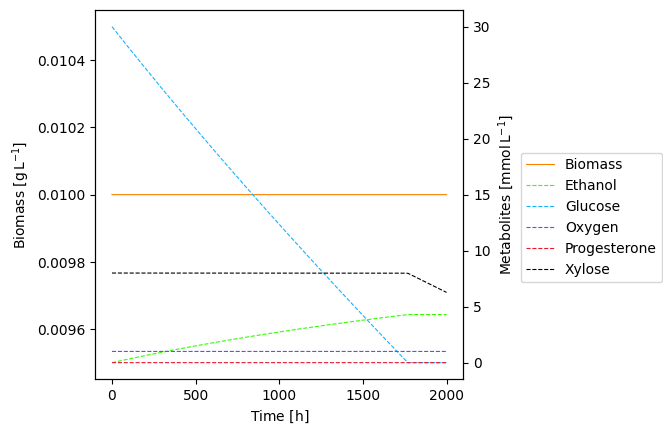

In [34]:
plot_concentrations(concentrations)

In [118]:
?plot_concentrations

Signature:
plot_concentrations(
    results: pandas.core.frame.DataFrame,
    metabolites: Union[List[str], NoneType] = None,
    biomass: str = 'Biomass',
    time: str = 'time',
    labels: Union[Dict[str, str], NoneType] = None,
    x_axis_title: str = 'Time $\\left[ \\mathrm{h} \\right]$',
    left_y_axis_title: str = 'Biomass $\\left[ \\mathrm{g} \\, \\mathrm{L}^{-1} \\right]$',
    right_y_axis_title: str = 'Metabolites $\\left[ \\mathrm{mmol} \\, \\mathrm{L}^{-1} \\right]$',
) -> None
Docstring:
Plot the concentration results of a dynamic FBA simulation.

The resulting plot can be further customized using ``matplotlib.pyplot``.

Parameters
----------
results : pandas.DataFrame
    The concentration results of a simulation.
metabolites : list of strings, optional
    The names of the metabolites in the data frame (default: all columns
    except for time and biomass).
biomass : str, optional
    The name of biomass in the results (default "Biomass").
time : str, optional
    The 

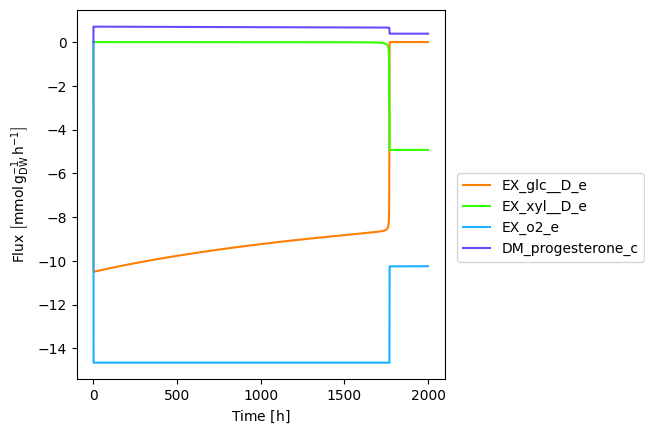

In [35]:
plot_trajectories(trajectories)